

## Creating a predictive model to predict the worth of a property

### <p style ="color: blue;">1. Introduction</p>

<p>The purpose of this project is to build a predictive model that will predict the price or worth of a property, allowing us to determine which newly launched property is worth investing in. There exists a mountain of property listings in Kuala Lumpur. The question then, is which of these properties are actually worth purchasing and investing in? By creating a predictive model that is able to predict a property's market price or value, we would potentially be able to evaluate whether certain property listings are overpriced, or underpriced and therefore worthy long-term investments. In this project, I created a spider to scrape data on various property listings from the property listing website www.propsocial.my, processed the data, evaluated the signifiance of the data obtained, and built a predictive model that will be able to predict the price or worth of a property based on its attributes.</p>


### <p style ="color: blue;">2. Data Collection</p>

<p>To collect data on available properties in Kuala Lumpur, I used beautifulsoup to create a spider that will scrape meaningful HTML information on property listings available on the property listing website www.propsocial.my.
HTML data on property listings and meaningful attributes of each property such as their price, number of bedrooms, property type were scraped to use as data for my predictive model</p>


In [ ]:
# install beautifulsoup to scrape websites
conda install -c anaconda beautifulsoup4

In [2]:
# import necessary packages for this assignment
import platform
from os import getcwd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from random import randint
import scipy.stats as stats
import pylab

<p>The propsocial website contains 1958 index pages on property listings in Kuala Lumpur at the time of writing.
As I lacked the hardware and RAM necessary for scraping all 1958 index pages in one go, the scrape process will be repeated with small batches, scraping multiple batches of consecutive index pages each time and combining them into one dataframe after. Due to hardware limitations and the vast amount of time needed to scrape all 1958 listings on the website on my computer, I decided to only scrape 800 pages, about 40% of the available listings. However, the resulting dataset still contained 12000 entries, which should be sufficient to create an accurate predictive model</p>

In [ ]:
#create an array to loop through webpage indexes
pageno = np.arange(401,801,1)

#Since I lack the necessary hardware and RAM for scraping all sites in one go, the scrape process is repeated by 
#changing the values in pageno and repeating the scrape process for different page indexes, creating multiple csv files
#and compiling those csv files together

#create dataframe with columns to scrape data into
df = pd.DataFrame (columns = ['Name','Price','LeaseType','PropertyType','Size','Furnished','Bedrooms','Bathrooms','Medianpsf','Views','Latitude','Longitude','Address'])
#create variable resultno just to print number as spider scrapes each listing, as a visual checker
resultno = 0
#loop pageno array to scrape multiple pages
for a in pageno:
    page = requests.get('https://www.propsocial.my/buy/kuala-lumpur-33?page='+str(a))
    soup = BeautifulSoup(page.content, 'html.parser')
    #find all divs that contain listings
    results = soup.find_all("div", class_= ["col-lg-6 col-md-6 col-sm-6 col-xs-12 classified-ad-details", "col-lg-7 col-md-7 col-sm-7 col-xs-12 classified-ad-details"])
    for x in results:
        #scrape name
        name = (x.find('div', class_='col-lg-12 col-md-12 col-sm-12 col-xs-12 nopadding').text.strip())
        #scrape price
        price = (x.find('span', class_='fullprice'))
        #scrape details
        details = x.find_all('div', class_='col-lg-12 col-md-12 col-sm-12 col-xs-12 nopadding classified-ad-specific-detail')
        if None in (name, price, details):
            continue
        #add details to a list 
        detaillist = []
        for y in details:
            detaillist.append((y.text.strip()))
        #find proceeding link of each listing to scrape further data
        link = x.find('a')
        listinglink = 'https://www.propsocial.my' + link['href']
        URL2 = listinglink
        page2 = requests.get(URL2)
        soup2 = BeautifulSoup(page2.content, 'html.parser')
        #scrape medianpricepersquarefeet
        medpricesqf = soup2.find('span', class_='fs13') if soup2.find('span', class_='fs13') else "N/A"
        #scrape reaches
        reaches = soup2.find('span', class_='view-count') if soup2.find('span', class_='view-count') else "N/A"
        #find next link in each page to scrape further data
        furtherlinks = soup2.find_all('a', class_='btn btn-darkblue btn-ex-lg white-space-init wow pulse hvr-grow')
        linklist = []
        for a in soup2.find_all('a', class_='btn btn-darkblue btn-ex-lg white-space-init wow pulse hvr-grow'):
            newlink = a['href']
            linklist.append(newlink)
        detaillink = 'https://www.propsocial.my' + linklist[1]
        URL3 = detaillink
        page3 = requests.get(URL3)
        soup3 = BeautifulSoup(page3.content, 'html.parser')
        #scrape latitude and longitude
        lat = soup3.find(id = '_lat')['value'] if soup3.find(id = '_lat')['value'] else "N/A"
        lng = soup3.find(id = '_lng')['value'] if soup3.find(id = '_lng')['value'] else "N/A"
        #scrape address
        address = soup3.find('div', class_='address').text.strip() if soup3.find('div', class_='address') else "N/A"
        #add scraped values into dataframe
        df = df.append({'Name':name, 'Price':(price.text.strip()),'LeaseType':detaillist[0], 'PropertyType':detaillist[1], 'Size':detaillist[2], 'Furnished':detaillist[3],'Bedrooms':detaillist[4],'Bathrooms':detaillist[5],'Medianpsf':(medpricesqf.text.strip()),'Views':reaches,'Latitude':lat,'Longitude':lng,'Address':address}, 
                ignore_index = True)
        #increase resultno value by 1 and print it as visual checker
        resultno+=1
        print(resultno)
#export dataframe to csv. This process is repeated to create multiple csv files since the team does not possess the hardware
#to store all webindex results in one scrape
df.to_csv (r'C:\Users\ROSC-01\Documents\export_dataframe4.csv', index = False, header=True) 

In [ ]:
#concat all csv files together into one combined csv
from glob import glob
filenames = glob("data/export_dataframe*.csv")
dataframes = [pd.read_csv(f) for f in filenames]
combineddata = pd.concat(dataframes,ignore_index=True)
combineddata.to_csv (r'C:\Users\ROSC-01\Documents\combinedataframe.csv', index = False, header=True)

<p>The resulting 'combinedataframe.csv' file contains the combined property listing data scraped from the propsocial website. The data obtained must then be cleaned before fitting into our predictive model</p>

### <p style ="color: blue;">3. Exploratory Data Analysis</p>

My combinedataframe dataset has 12000 entries. However, there are missing or NA values in the dataset. There are also unreasonable values, such as values of '0' in Price, likely caused by sellers open to negotiating those prices and placing 0 as a placeholder. Furthermore, there are redundant values in certain columns, e.g. the 'Views' column still has html metadata leftover in the column, and needs to be removed since we only want the number of views. The analysis of each attribute and its cleaning process is respectively shown below:


In [7]:
df = pd.read_csv('data/combinedataframe.csv')
df.info()
df.head()
#My combinedataframe dataset has 12000 entries. However, there are missing or NA values in the dataset. The dataset 
#will need to be properly cleaned before exploration and visualisation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          12000 non-null  object 
 1   Price         12000 non-null  object 
 2   LeaseType     12000 non-null  object 
 3   PropertyType  12000 non-null  object 
 4   Size          11904 non-null  object 
 5   Furnished     12000 non-null  object 
 6   Bedrooms      12000 non-null  object 
 7   Bathrooms     12000 non-null  object 
 8   Medianpsf     12000 non-null  object 
 9   Views         11964 non-null  object 
 10  Latitude      12000 non-null  float64
 11  Longitude     12000 non-null  float64
 12  Address       10528 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB


,Name,Price,LeaseType,PropertyType,Size,Furnished,Bedrooms,Bathrooms,Medianpsf,Views,Latitude,Longitude,Address
0,"Arte Mont Kiara, Dutamas","For Sale: RM 1,100,000",Freehold,Serviced Residence,925 SQ. FT,Fully Furnished,2 Bedrooms,1 + 1 Bathrooms,(RM 1189.19 psf),"<span class=""view-count"">3</span>",3.176510,101.665506,"Jalan Sultan Haji Ahmad Shah, 50480 Kuala Lump..."
1,"VERVE Suites, Mont Kiara","For Sale: RM 768,000",Freehold,Serviced Residence,861 SQ. FT,Fully Furnished,2 Bedrooms,2 Bathrooms,(RM 891.99 psf),"<span class=""view-count"">3</span>",3.167410,101.646000,"Taman Sri Hartamas, 5, Jalan Kiara, Mont Kiara..."
2,"Damai Residence, Sungai Besi","For Sale: RM 601,000",Freehold,Condominium,910 SQ. FT,Fully Furnished,3 Bedrooms,2 Bathrooms,(RM 660.44 psf),"<span class=""view-count"">5</span>",3.116250,101.708361,"326, Jalan Sungai Besi, Sungai Besi, 55200 Kua..."
3,"Damai Residence, Sungai Besi","For Sale: RM 599,000",Freehold,Condominium,910 SQ. FT,Fully Furnished,3 Bedrooms,2 Bathrooms,(RM 658.24 psf),"<span class=""view-count"">4</span>",3.116250,101.708361,"326, Jalan Sungai Besi, Sungai Besi, 55200 Kua..."
4,"Taman Segar Perdana, Cheras","For Sale: RM 750,000",Leasehold,Terrace,"2,000 SQ. FT",Semi Furnished,4 Bedrooms,3 Bathrooms,(RM 375.0 psf),"<span class=""view-count"">6</span>",3.091579,101.760285,"Taman Segar Perdana, Batu 9 Cheras, 43200 Cher..."


### <p style="color:Blue;">3.1 Data cleaning and pre-processing</p>

#### <p style="color:Blue;">Cleaning Price attribute</p>

In [8]:
#Price
#We want to convert the values to a float type and remove unnecessary text
#Remove 'For Sale', 'RM', 'Auction', commas, and so on
df["Price"]=df["Price"].replace("For Sale: RM","",regex=True)
df["Price"]=df["Price"].replace("Auction","",regex=True)
df["Price"]=df["Price"].replace("\n","",regex=True)
df["Price"]=df["Price"].replace("''","",regex=True)
df["Price"]=df["Price"].replace(",","",regex=True)
df["Price"]=df["Price"].replace("@","",regex=True)
df["Price"]=df["Price"].replace("RM","",regex=True)
#change datatype to float
df["Price"]=df.Price.astype(float)

#There are no NA or Missing values, but there are values of 0, which are impossible. These 0 values of price will 
#later be calculated from their medianpsf times size values after we have changed medianpsf datatype to float


#### <p style="color:Blue;">Manipulating Leasetype attribute</p>

In [9]:
#Leasetype
#There are no NA or missing values in Leasetype
#We want to convert Leasetype string variables into numerical categorical variables to be used in our predictive model
#View how many unique values there are in 'Leasetype' column
df['LeaseType'].unique()
#There are only two types of values: Freehold and Leasehold
#Replace string values with numerical values. Freehold will be given value of 1, Leasehold will be given a value of 2
df['LeaseType'] = df['LeaseType'].replace('Freehold', 1, regex=True)
df['LeaseType'] = df['LeaseType'].replace('Leasehold', 2, regex=True)
df['LeaseType'] = df.LeaseType.astype(int)
#Check new values
df['LeaseType'].head()

0    1
1    1
2    1
3    1
4    2
Name: LeaseType, dtype: int32

#### <p style="color:Blue;">Manipulating Propertytype attribute</p>

In [10]:
#Propertytype
#There are no Missing or NA values in Propertytype
#We want to convert Propertytype string variables into numerical variables
#View how many unique values there are in 'Propertytype' column
df['PropertyType'].unique()
#There are only two types of values: Freehold and Leasehold
#Replace string values with numerical values. The representation of values is provided below:
#Serviced Residence = 1
#Condominium = 2
#Terrace = 3
#Superlink = 4
#Apartment = 5
#Land = 6
#Semi Detached = 7
#Villa = 8
#Shop = 9
#Bungalow = 10
#Office = 11
#Factory = 12
#So Ho/Studio = 13
#Duplex = 14
#Link = 15
#Townhouse = 16
df['PropertyType'] = df['PropertyType'].replace('Serviced Residence', 1, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Condominium', 2, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Terrace', 3, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Superlink', 4, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Apartment', 5, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Land', 6, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Semi Detached', 7, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Villa', 8, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Shop', 9, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Bungalow', 10, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Office', 11, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Factory', 12, regex=True)
df['PropertyType'] = df['PropertyType'].replace('So Ho/Studio', 13, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Duplex', 14, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Link', 15, regex=True)
df['PropertyType'] = df['PropertyType'].replace('Townhouse', 16, regex=True)
df['PropertyType'] = df.PropertyType.astype(int)
#Check new values
df['PropertyType'].head()

0    1
1    1
2    2
3    2
4    3
Name: PropertyType, dtype: int32

#### <p style="color:Blue;">Cleaning Size attribute</p>

In [11]:
#Size
#There are 97 missing values in Size. There are also values of '0 SQ. FT', which is impossible
#We want to convert the values to an integer type and remove unnecessary text
#Remove 'SQ. FT', commas and black space
df['Size'] = df['Size'].str.strip()
df['Size'] = df['Size'].replace('SQ. FT', '', regex=True)
df['Size'] = df['Size'].replace(',', '', regex=True)
#replace missing and NaN values with consistent value of 0
df['Size'] = df['Size'].replace('', 0, regex=True)
df['Size'] = df['Size'].replace(np.nan, 0, regex=True)
#check if any nan values exist
#print(data[data['Size'].isnull()])
#change datatype to int
df['Size'] = df.Size.astype(int)
#We now have consistent value of 0 for all previous missing values, and error entries of 0 SQ. FT
#To compute missing values, we will use the mean size of different properties. Different properties like condominiums, 
#apartments and bungalows have different property sizes
#Missing size values will be computed with estimated means of their property size 
#Fill missing values in size with mean size based on propertytype
df['Size'] = df['Size'].replace(0, np.nan)
df['Size']= df['Size'].fillna(df.groupby('PropertyType')['Size'].transform('mean'))

#### <p style="color:Blue;">Manipulating Furnished attribute</p>

In [12]:
#Furnished
#There are no NA or missing values in Leasetype
#We want to convert Furnished string variables into numerical categorical variables to be used in our predictive model
#View how many unique values there are in 'Furnished' column
df['Furnished'].unique()
#There are only three types of values: Unfurnished, Semi Furnished and Fully Furnished
#Replace string values with numerical values. Unfurnished will be given a value of 0
# Semi Furnished will be given value of 1, Fully Furnished will be given a value of 2
df['Furnished'] = df['Furnished'].replace('Unfurnished', 0, regex=True)
df['Furnished'] = df['Furnished'].replace('Semi Furnished', 1, regex=True)
df['Furnished'] = df['Furnished'].replace('Fully Furnished', 2, regex=True)
df['Furnished'] = df.Furnished.astype(int)
#Check new values
df['Furnished'].head()


0    2
1    2
2    2
3    2
4    1
Name: Furnished, dtype: int32

#### <p style="color:Blue;">Cleaning Bedrooms attribute</p>

In [13]:
#Bedrooms
#We first remove the unnecessary text 
#Remove blank spaces and special characters
#For example, 1+1 Bedrooms data will be replaced with 2 for calculation purposes
df["Bedrooms"]=df["Bedrooms"].str.strip()
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['Bedrooms'] = df['Bedrooms'].str.replace(char, ' ')
df["Bedrooms"]=df["Bedrooms"].replace("Bedrooms","",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace('1   1','2',regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("4   1","5",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("3   1","4",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("2   1","3",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("5   2","7",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("5   1","6",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("3   2","5",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("4   3","7",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("6   1","7",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("4   2","6",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("7   1","8",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("2   2","4",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("8   1","9",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("5   3","8",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("4   4","8",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("6   2","8",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("1   3","4",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("3   4","7",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("7   2","9",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("0   1","1",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("40   5","45",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("47   1","48",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("10   2","12",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("9   2","11",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("9   1","10",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("6   3","9",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("0   4","4",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("8   2","10",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("0   5","5",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("3   5","8",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("0   3","3",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("1   2","3",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("9   3","12",regex=True)
df["Bedrooms"]=df["Bedrooms"].replace("6   4","10",regex=True)
#Properties with NA value in 'Bedrooms' column will be changed to an empty cell
#For properties that have missing value for 'Bedrooms', will be replaced by the median of the Bedrooms depending on the Property Type
df["Bedrooms"]=df["Bedrooms"].replace("N   A","",regex=True)
df["Bedrooms"]=pd.to_numeric(df["Bedrooms"])
df["Bedrooms"].fillna(df.groupby("PropertyType")["Bedrooms"].transform("median"),inplace=True)
#change datatype to integer
df["Bedrooms"]=df.Bedrooms.astype(int)
#View the unique values in 'Bedrooms column'
df['Bedrooms'].unique()

array([  2,   3,   4,   6,   0,   9,   5,   1,   7,   8,  10, 180,  45,
        48, 110,  11,  12,  60,  14,  30])

#### <p style="color:Blue;">Cleaning Bathrooms attribute</p>

In [14]:
#Bathrooms
#We first remove the unnecessary text 
#Remove special characters
#For example, 1+1 Bathrooms data will be replaced with 2 for calculation purposes
df["Bathrooms"]=df["Bathrooms"].str.strip()
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['Bathrooms'] = df['Bathrooms'].str.replace(char, ' ')
df["Bathrooms"]=df["Bathrooms"].replace("Bathrooms","",regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('1   1','2',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('2   1','3',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('4   2','6',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('4   1','5',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('3   1','4',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('6   1','7',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('2   2','4',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('5   1','6',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('7   1','8',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('8   1','9',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('3   2','5',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('6   2','8',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('7   2','9',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('5   2','7',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('40   5','45',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('47   1','48',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('0   2','2',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('9   1','10',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('0   1','1',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('3   3','6',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('1   2','3',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('10   2','12',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('6   3','9',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('3   5','8',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('4   3','7',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('0   3','3',regex=True)
df["Bathrooms"]=df["Bathrooms"].replace('0   4','4',regex=True)
#Properties with NA value in 'Bathrooms' column will be changed to an empty cell
#For properties that have missing value for 'Bathrooms', will be replaced by the median of the Bathrooms depending on the Property Type
df["Bathrooms"]=df["Bathrooms"].replace("N   A","",regex=True)
df["Bathrooms"]=pd.to_numeric(df["Bathrooms"])
df["Bathrooms"].fillna(df.groupby("PropertyType")["Bathrooms"].transform("median"),inplace=True)
#change datatype to integer
df["Bathrooms"]=df.Bathrooms.astype(int)
#View the unique values in 'Bathrooms' column
df['Bathrooms'].unique()

array([  2,   3,   4,   1,   0,   5,   6,   7,   8,   9,  10, 180,  45,
        48, 110,  12,  13,  60,  15,  72,  11])

#### <p style="color:Blue;">Cleaning Medianpsf attribute</p>

In [15]:
#Medianpsf
#filter medianpsf to get only numerical value
df['Medianpsf'] = df['Medianpsf'].str.strip()
df["Medianpsf"]=df["Medianpsf"].replace(r"\(","",regex=True)
df["Medianpsf"]=df["Medianpsf"].replace(r"\)","",regex=True)
df["Medianpsf"]=df["Medianpsf"].replace("RM","",regex=True)
df["Medianpsf"]=df["Medianpsf"].replace("psf","",regex=True)
df["Medianpsf"]=df.Medianpsf.astype(float)
#check new values
df['Medianpsf'].head()
#Replace price values of 0 with price per square feet multiplied by square feet
df['Price'] = np.where(df['Price']==0, df['Size']*df['Medianpsf'], df['Price'])
#There are still rows with values of 0 in price, since they also have values of 0 in medianpsf. However, the amount of rows
#with these problems are low(56 rows), and as such are removed
priceindex = df[ df['Price'] == 0 ].index
df.drop(priceindex, inplace=True)

#### <p style="color:Blue;">Cleaning Views attribute</p>

In [16]:
#Views
#We want to convert the values to an integer type and remove unnecessary text
#Remove '<span class="view-count"></span>' in the Views column
df["Views"]=df["Views"].replace("<","",regex=True)
df["Views"]=df["Views"].replace("span","",regex=True)
df["Views"]=df["Views"].replace("class","",regex=True)
df["Views"]=df["Views"].replace("=","",regex=True)
df["Views"]=df["Views"].replace('"',"",regex=True)
df["Views"]=df["Views"].replace('view',"",regex=True)
df["Views"]=df["Views"].replace('-',"",regex=True)
df["Views"]=df["Views"].replace('count',"",regex=True)
df["Views"]=df["Views"].replace('>',"",regex=True)
df["Views"]=df["Views"].replace('/',"",regex=True)
df["Views"]=df["Views"].replace('>',"",regex=True)
#There are missing values of views. However, it is possible that a property with missing values of views could mean that
#there simply hasn't been anyone viewing it yet. Thus, we will replace missing values with consistent value of 0
df["Views"]=df.Views.fillna(0)
#change datatype to integer
df["Views"]=df.Views.astype(int)

#### <p style="color:Blue;">Cleaning address attribute</p>

In [17]:
#address
#there are 1604 rows with missing values in address
#Since each data entry's 'name' also shares valuable information about an address, 
#missing values in the 'address' column will be filled with the same value of their 'name column'
#The lack of address in the dataset should not be a problem since even without address values, 
#the dataset still contains 'lat' and 'lng' values which are even more accurate descriptions of address
#replace missing address values with name values
df['Address']=df['Address'].fillna(df['Name'])
#check if any nan values exist
print(df[df['Address'].isnull()])

Empty DataFrame
Columns: [Name, Price, LeaseType, PropertyType, Size, Furnished, Bedrooms, Bathrooms, Medianpsf, Views, Latitude, Longitude, Address]
Index: []


<p>I have successfully removed all missing and NA values from each attribute, as well as 
removed redundant information like unwanted string and html metadata leftoever from the scraping process,
and error information like 0 values for price. Finally, I can move on to removing duplicate data. I determined
duplicate entries as entries that not only have the same Name, but also the same LeaseType, PropertyType, Size,
Furnished status, Number of Bedrooms, Number of Bathrooms, and property location. This is because properties with the
same name could still be properties in the same address but with different sizes, furnished status, 
number of bedrooms and bathrooms and property type, and therefore be more or less expensive. 
Properties with the same name could also be sold with different leasetypes, and such distinction between entries 
is important for our predictive model</p>

In [18]:
#remove duplicate values by checking the name, address, leasetype, propertype, bedrooms, bathrooms
df[df.duplicated(subset=["Name", "LeaseType", "PropertyType", "Size", "Furnished", "Bedrooms", "Bathrooms", "Latitude", "Longitude", "Address"])]
df.drop_duplicates(subset=["Name", "LeaseType", "PropertyType", "Size", "Furnished", "Bedrooms", "Bathrooms", "Latitude", "Longitude", "Address"], keep="first", inplace=True)
#keep = 'first' will recognise the first duplicate value as a unique value, and discard the rest of the duplicate values
#I decided to use keep = 'first' since the dataset was scraped from index pages 1-800, and newer or modern
#listings of a property with updated price would be on the earlier index pages
df.reset_index(drop=True, inplace=True)

In [19]:
#check new dataframe
df.info()

#The dataframe contains 12000 entries with 13 columns. These columns and their descriptions in order are
#Name - The name of the listing
#Price - The selling price of the listing in Ringgit Malaysia
#LeaseType - The type of lease of the listing e.g. Freehold/Leasehold
#PropertyType - The property type of the listing e.g. Condominium, Bungalow
#Size - The size of the listing measured in square feet
#Furnished - The furnished status of the listing e.g. Fully Furnished, Unfurnished
#Bedrooms - The number of bedrooms in the listing
#Bathrooms - The number of Bathrooms in the listing
#Medianpsf - The median price per square feet of the listing
#Views - The amount of times the listing has been viewed on the website
#Latitude - The latitude coordinates of the listing
#Longitude - The longitude coordinates of the listing
#Address - The address of the listing 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9011 non-null   object 
 1   Price         9011 non-null   float64
 2   LeaseType     9011 non-null   int32  
 3   PropertyType  9011 non-null   int32  
 4   Size          9011 non-null   float64
 5   Furnished     9011 non-null   int32  
 6   Bedrooms      9011 non-null   int32  
 7   Bathrooms     9011 non-null   int32  
 8   Medianpsf     9011 non-null   float64
 9   Views         9011 non-null   int32  
 10  Latitude      9011 non-null   float64
 11  Longitude     9011 non-null   float64
 12  Address       9011 non-null   object 
dtypes: float64(5), int32(6), object(2)
memory usage: 704.1+ KB


In [20]:
#export new pre-processed dataset
df.to_csv (r'C:\Users\ROSC-01\Documents\processedcombinedataframe.csv', index = False, header=True)

<p>Now that the dataset has been cleaned, I'll explore the attributes in the dataset and evaluate each attribute
on whether it has a relation to a property's pricing. The exploratory data analysis of each attribute is shown below:</p>

### <p style="color:Blue;">3.2 Data Analysis </p>

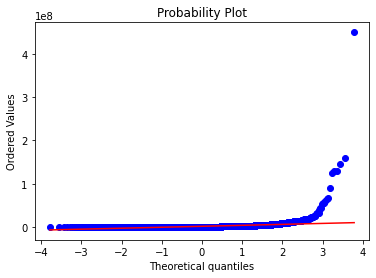

In [16]:
#Since Price is our dependant variable that we want to predict, I first checked the 'Price''s normality
#This helped me to determine whether to use parametric or non-parametric tests when exploring association between
#different attributes and price
#Check normality of Price
stats.probplot(df['Price'], dist="norm", plot=pylab)
pylab.show()
#The probability plot shows that there is no linear relationship, probability cannot be assumed
#Normal distribution cannot be assumed.

#### <p style="color:Blue;">Exploring LeaseType attribute</p>

F_onewayResult(statistic=3.736334767107858, pvalue=0.053272413013770344)

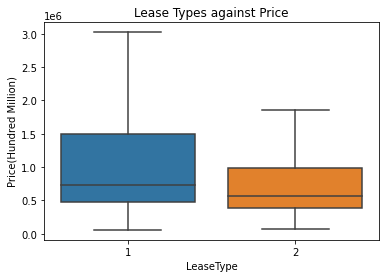

In [17]:
#plot boxplot to check distribution of Price for properties based on their LeaseType
sns.boxplot(x = 'LeaseType', y = 'Price', data = df, showfliers=False)
plt.title('Lease Types against Price')
plt.xlabel('LeaseType')
plt.ylabel('Price(Hundred Million)')
#The data distribution and range of Price for properties with different LeaseTypes differs greatly
#A statistical correlation test will be conducted to further check correlation between LeaseType and Price
#A one way Anova test will be used to test correlation since we are testing for categorical independant variables
#without rank affecting continous variable price
#Null Hypothesis: there is no difference in mean in Price between properties with different LeaseTypes
stats.f_oneway(df['Price'][df['LeaseType'] == 1],
               df['Price'][df['LeaseType'] == 2])
#pvalue(0.0533)>0.05 tells us that we do not have enough evidence to reject the null hypothesis. However since the pvalue
#obtained is actually quite close to the 95% confidence interval and the f-statistic(3.736) is reasonably high, the team
#will use this attribute in the predictive model

#### <p style="color:Blue;">Exploring PropertyType attribute</p>

Text(0, 0.5, 'Price(Hundred Million)')

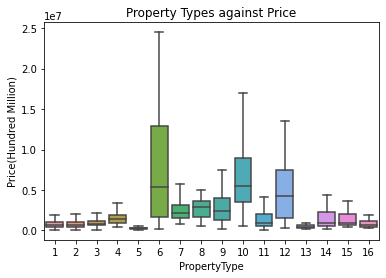

In [18]:
#plot boxplot to compare data distribution of price based on property type
sns.boxplot(x = 'PropertyType', y = 'Price', data = df, showfliers=False)
plt.title('Property Types against Price')
plt.xlabel('PropertyType')
plt.ylabel('Price(Hundred Million)')
#PropertyType 6,8, 10 and 12 or Land, Villa, Bungalow and Factory have the highest median prices


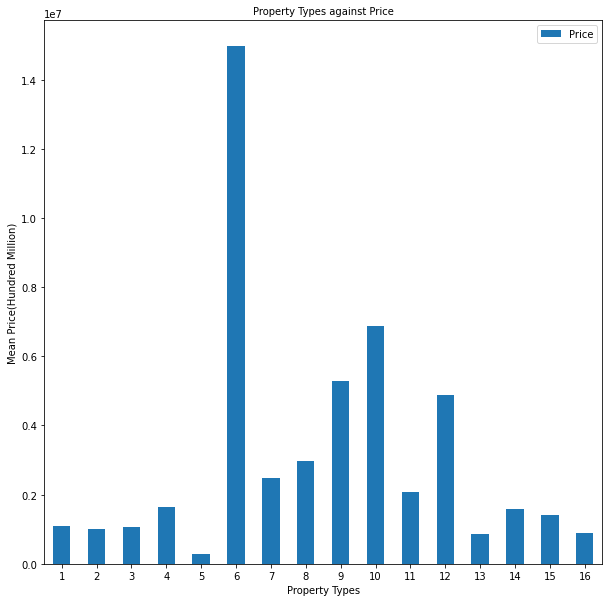

In [19]:
#Compare mean price of each property type
f1 = df.groupby(['PropertyType'])['Price'].mean()
f1.plot(kind='bar', figsize=(10, 10), legend=True, fontsize=10)
plt.title("Property Types against Price",fontsize=10)
plt.ylabel('Mean Price(Hundred Million)',fontsize=10)
plt.xlabel("Property Types",fontsize=10)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)
plt.legend(loc=0, fontsize=10)
plt.show()
#Property Type 6(Land), 10(Bungalow) and 9(Shop) have the highest prices
#5(Apartment) and 13(Soho Studios) have the lowest price
#There seems to be clear differences in mean and price range between different property types

In [20]:
#A one way Anova test will be conducted to further check
#Null Hypothesis: there is no difference in mean in Price between properties with different PropertyTypes
stats.f_oneway(df['Price'][df['PropertyType'] == 1],
               df['Price'][df['PropertyType'] == 2], 
               df['Price'][df['PropertyType'] == 3],
               df['Price'][df['PropertyType'] == 4],
               df['Price'][df['PropertyType'] == 5],
               df['Price'][df['PropertyType'] == 6],
               df['Price'][df['PropertyType'] == 7],
               df['Price'][df['PropertyType'] == 8],
               df['Price'][df['PropertyType'] == 9],
               df['Price'][df['PropertyType'] == 10],
               df['Price'][df['PropertyType'] == 11],
               df['Price'][df['PropertyType'] == 12],
               df['Price'][df['PropertyType'] == 13],
               df['Price'][df['PropertyType'] == 14],
               df['Price'][df['PropertyType'] == 15],
               df['Price'][df['PropertyType'] == 16])
#Pvalue(1.3829e-202)<0.05, there is very significant difference between the price of different property types.
#property type will be used in our predictive model

F_onewayResult(statistic=70.10921166762303, pvalue=1.3829142248913228e-202)

#### <p style="color:Blue;">Exploring Size attribute</p>

SpearmanrResult(correlation=0.7783496627142155, pvalue=0.0)

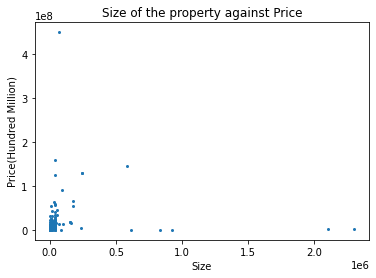

In [21]:
#Plot scatter plot of size against price
plt.plot(df['Size'], df['Price'], 'o', markersize=2)
plt.title('Size of the property against Price')
plt.xlabel('Size')
plt.ylabel('Price(Hundred Million)')
#Based on the graph it is hard to tell any relationships since the density of the data is located in the lower values
#A spearman correlation test will be conducted since they are both continous variables and price is non parametric,
#to help us identify any relationships
#Null Hypothesis: there is no association between Size and Price
stats.spearmanr(df['Size'], df['Price'])
#pvalue = 0, there is no relationship between size and price

#### <p style="color:Blue;">Exploring Furnished attribute</p>

SpearmanrResult(correlation=0.12790555516616586, pvalue=3.513688514106648e-34)

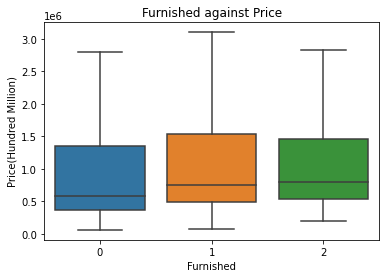

In [22]:
#Plot boxplot of furnished status to compare median prices
sns.boxplot(x = 'Furnished',y = 'Price', data = df, showfliers=False)
plt.title('Furnished against Price')
plt.xlabel('Furnished')
plt.ylabel('Price(Hundred Million)')
#There dosen't seem to be a significant difference between the data distribution of each furnished status
#A spearman correlation test will be conducted to test for association between furnished status and price
#spearman will be used since our data is ordinal(unfurnished to fully furnished) and price is non parametric
#Null Hypothesis: there is no association between furnished status and price
stats.spearmanr(df['Furnished'], df['Price'])
#pvalue(3.514e-34)<0.05, there is significant association between furnished status and price. The correlation 
#coefficiant 0.1279 also tells us that there is a positive correlation and price increases if the property is furnished

#### <p style="color:Blue;">Exploring Bedrooms attribute</p>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

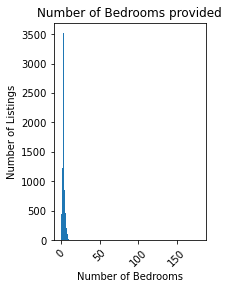

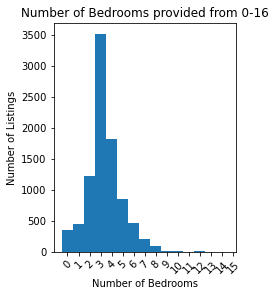

In [23]:
#Scatterplot of number of bedrooms against price
plt.subplot(1,2,1)
plt.hist(df['Bedrooms'], bins=np.arange(df['Bedrooms'].min(), df['Bedrooms'].max())-0.5)#the -0.5 is just to align the bars with x label
plt.title('Number of Bedrooms provided')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.subplots(constrained_layout=True)
#a large portion of the data is in the lower values of number of bedrooms. We will plot a second scatterplot to 
#focus on those values
plt.subplot(1,2,2)
plt.hist(df['Bedrooms'], bins=np.arange(16)-0.5)
plt.title('Number of Bedrooms provided from 0-16')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Listings')
plt.xticks(range(16))
plt.xticks(rotation=45)
#The data seems normally distributed, 3, 4 and 2 are the most common amount of bedrooms offered

SpearmanrResult(correlation=0.44813283239785046, pvalue=0.0)

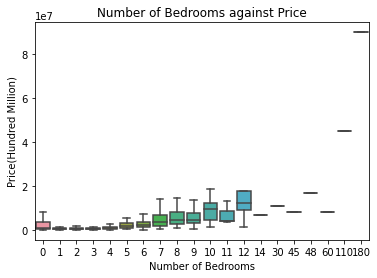

In [24]:
#plot boxplot to compare price distribution of number of bedrooms
sns.boxplot(x = 'Bedrooms',y = 'Price', data = df, showfliers=False)
plt.title('Number of Bedrooms against Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price(Hundred Million)')
#The median price seems to increase after 4 bedrooms. 
#A spearmans test will be conducted to test for any association between no. of bedrooms and price
#Null Hypothesis: there is no association between no. of bedrooms and price
stats.spearmanr(df['Bedrooms'], df['Price'])
#pvalue = 0, there is no association

#### <p style="color:Blue;">Exploring Bathroom attribute</p>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

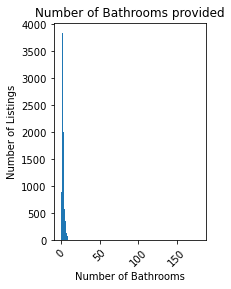

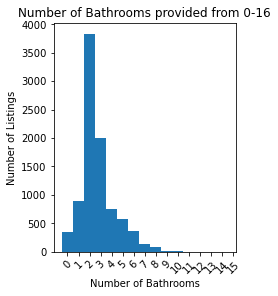

In [25]:
#View histogram of number of bathrooms to see most common offered number of bathrooms
df['Bathrooms'].unique()
#Unique array returned is array([  2,   3,   4,   1,   0,   5,   6,   7,   8,   9,  10, 180,  45,
#        48, 110,  12,  13,  60,  15,  72,  11])
#There are 16 different unique entries in PropertyType
plt.subplot(1,2,1)
plt.hist(df['Bathrooms'], bins=np.arange(df['Bathrooms'].min(), df['Bathrooms'].max())-0.5)#the -0.5 is just to align the bars with x label
plt.title('Number of Bathrooms provided')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.subplots(constrained_layout=True)
#There is high data density on the left, and values like 180 and 45 bathrooms occur so few that they are not even visible
#on the graph when compared to the data density of the lower values. These values are thus extremities and outliers, possibly
#due to 'Land' listings, which have much higher sizes, and are thus able to offer more bathrooms, but occur rarely.
#A new histogram is plotted to focuse on the lower values
plt.subplot(1,2,2)
plt.hist(df['Bathrooms'], bins=np.arange(16)-0.5)
plt.title('Number of Bathrooms provided from 0-16')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Number of Listings')
plt.xticks(range(16))
plt.xticks(rotation=45)


#Based on the histogram, the most common offered number of bathrooms is 2 bathrooms, and it is by far the most common.
#The data is also skewered left

Text(0, 0.5, 'Price(Hundred Million)')

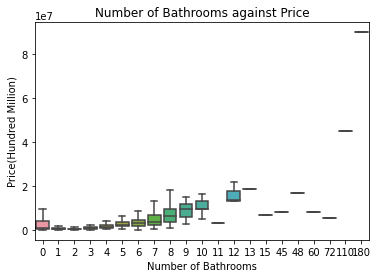

In [26]:
#Does number of bathrooms provided affect price?
#Draw boxplot to see whether median price increases for different number of bathrooms
sns.boxplot(x = 'Bathrooms',y = 'Price', data = df, showfliers=False)
plt.title('Number of Bathrooms against Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price(Hundred Million)')
#We can see that there is an increase in median price when the number of bathrooms increases. This increase in price only 
#occurs after 3 bathrooms though, and after 9 bathrooms, the median price of more bathrooms fluctuate. Fluctuation
#in the larger number of bathrooms entries might be due to the scarcity of data entries with such high number of bathrooms
#and thus not as accurate. Interestingly, we see that the upper quartile price range of different number of bathrooms
#actually decreases from 0 bathrooms to 2 bathrooms, but increases after that. 

In [27]:
#To further test whether bathrooms affect price, a correlation test will be conducted. Spearman's will be used since the
#data is non parametric
#Null Hypothesis: there is no association between no. of bathrooms and price
stats.spearmanr(df['Bathrooms'], df['Price'])
#p value = 0, there is no significant relationship between bathrooms and price. As such, the 'Bathrooms' attribute will not be
#used as a predictor in the predictive model

SpearmanrResult(correlation=0.5499555245081296, pvalue=0.0)

#### <p style="color:blue;">Exploring Views attribute</p>

SpearmanrResult(correlation=0.06683875428715765, pvalue=2.1395164725750515e-10)

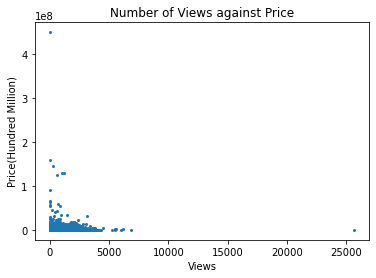

In [28]:
#Listings with more views might be indicative of higher demand, since they are viewed more and sought after more. As 
#such, views might be a significant predictor in price since it is a useful too to determine demand.
#Plot scatterplot of views against price
plt.plot(df['Views'], df['Price'], 'o', markersize=2)
plt.title('Number of Views against Price')
plt.xlabel('Views')
plt.ylabel('Price(Hundred Million)')
#Interestingly, there seems to be a negative correlation between price and views. However, it is a bit difficult to tell
#based on the scatterplot since there is high density 
#A correlation test will be conducted to further test this. Spearman will be used since they are both continous 
#and discrete variables and non parametric
#Null Hypothesis: there is no association between no. of views and price
stats.spearmanr(df['Views'], df['Price'])
#p-value(2.140e-10)<0.005, there is significant relationship between views and price. There is also a slight positive
#correlation(0.067). When views increase, price increase. Views will be used as a predictor in the model. 

#### <p style="color:blue;">Exploring listing location</p>

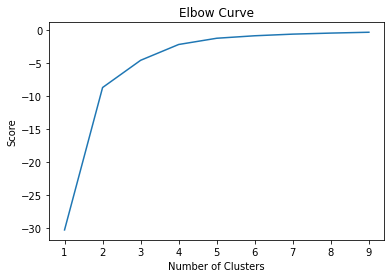

In [29]:
from sklearn.cluster import KMeans
#Does the location of a listing affect the price? We will use the 'Latitude' and 'Longitude' values of each listing to 
#determine its location, and use K-means clustering to identify distinct clusters between them. Instead of differentiating
#listings by their address e.g. district, town, or road, clustering the data based on its coordinates can reveal meaningful
#distinctions of listing locations that go beyond the normal limitations of state and town borders
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['Latitude']]
X_axis = df[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#Based on the elbow curve, the optimal number of clusters is 4

In [30]:
#Perform K-means clustering on latitude and longitude to find meaningful clusters between listing locations
X=df.loc[:,['Name','Latitude','Longitude']]
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(X[X.columns[1:4]]) 
df['location_cluster'] = kmeans.fit_predict(X[X.columns[1:4]])#Assign new location_cluster values to dataset entries
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(X[X.columns[1:4]])

C:\Users\ROSC-01\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0.5, 1.0, 'House Listings in Kuala Lumpur')

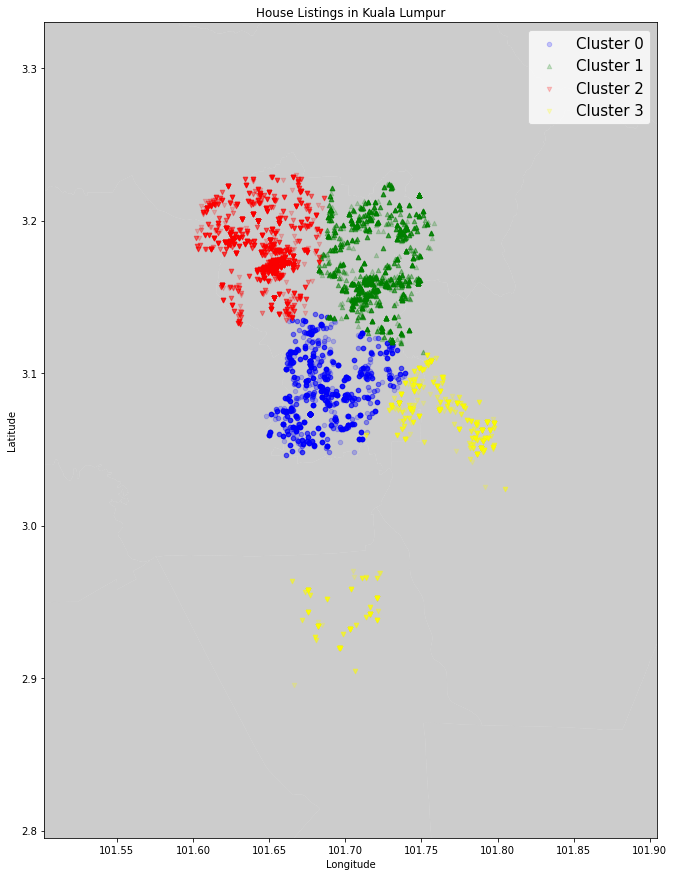

In [31]:
#plot a map of listing location clusters
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline
kl_map = gpd.read_file('states/polbnda_mys.shp')#read shapefile
crs = {'init': 'epsg:4326'}#set crs to map longitude and latitude
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
map_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)#.to_crs(epsg=3857)#create geo dataframe of lat and lon

minx, miny, maxx, maxy = map_df.total_bounds#get max and min bounds of lat and lon

fig, ax = plt.subplots(figsize=[15,15])
ax.set_xlim((minx-0.1), (maxx+0.1))#add padding to boundaries
ax.set_ylim((miny-0.1), (maxy+0.1))
kl_map.plot(ax=ax, alpha = 0.4, color='grey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#set different colors, markers, and change opacity to differentiate clusters easier
map_df[map_df['location_cluster']==0].plot(ax=ax, markersize = 20, color = 'blue', marker = 'o', alpha = 0.2, label = 'Cluster 0')
map_df[map_df['location_cluster']==1].plot(ax=ax, markersize = 20, color = 'green', marker = '^', alpha = 0.2, label = 'Cluster 1')
map_df[map_df['location_cluster']==2].plot(ax=ax, markersize = 20, color = 'red', marker = 'v',alpha = 0.2, label = 'Cluster 2')
map_df[map_df['location_cluster']==3].plot(ax=ax, markersize = 20, color = 'yellow', marker = 'v',alpha = 0.2, label = 'Cluster 3')

plt.legend(prop={'size':15})
plt.title('House Listings in Kuala Lumpur') 

<AxesSubplot:xlabel='location_cluster', ylabel='Price'>

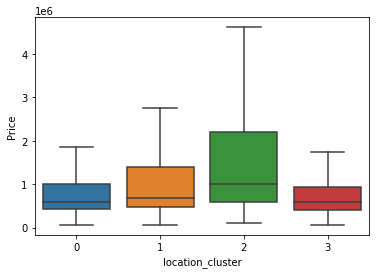

In [32]:
sns.boxplot(x = 'location_cluster',y = 'Price', data = df, showfliers=False)
#plot boxplot to compare price distributions between different location clusters

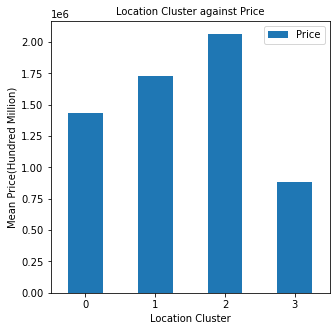

In [33]:
#Compare mean price of each location cluster
f2 = df.groupby(['location_cluster'])['Price'].mean()
f2.plot(kind='bar', figsize=(5, 5), legend=True, fontsize=10)
plt.title("Location Cluster against Price",fontsize=10)
plt.ylabel('Mean Price(Hundred Million)',fontsize=10)
plt.xlabel("Location Cluster",fontsize=10)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)
plt.legend(loc=0, fontsize=10)
plt.show()
#Based on the boxplot and bar graph, we see distribution and mean difference in price based on different location_clusters
#location_cluster will be used as a predictor in our model

<p>Based on the my EDA, significant attributes that affect price are LeaseType, PropertyType, Furnished status, Views
and location_cluster, the listing location. These attributes will be used as predictors to predict price in our predictive model.</p>


### <p style ="color: blue;">4. Model Building</p>

<p>For this project, I applied Random Forest Regression to build my predictive model. Random Forest Regression is a supervised learning algorithm that uses emsemble learning method for regression. The advantages of the Random Forest are that I can minimize overfitting and generate a separate holdout set that can be used as the validation set. Random Forest is also a good model for both categorical and continuous predictor data, which fits my dataset</p>

In [34]:
#We first sort the data by splitting it into 80% for training dataset and 20% for test set
x=np.floor(0.8*len(df))
x=x.astype(int)
train=df[:x]
test=df[x:]

In [35]:
#Drop variables that are not included as the predictors
train1=train.drop(["Name", "Size","Bedrooms", "Bathrooms", "Medianpsf", "Latitude", "Longitude", "Address", "geometry"], axis=1)
test1=test.drop(["Name", "Size", "Bedrooms", "Bathrooms", "Medianpsf", "Latitude", "Longitude", "Address", "geometry"], axis=1)

In [36]:
train1.head()

,Price,LeaseType,PropertyType,Furnished,Views,location_cluster
0,1100000.0,1,1,2,3,2
1,768000.0,1,1,2,3,2
2,601000.0,1,2,2,5,0
3,750000.0,2,3,1,6,3
4,500000.0,1,2,0,28,1


C:\Users\ROSC-01\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


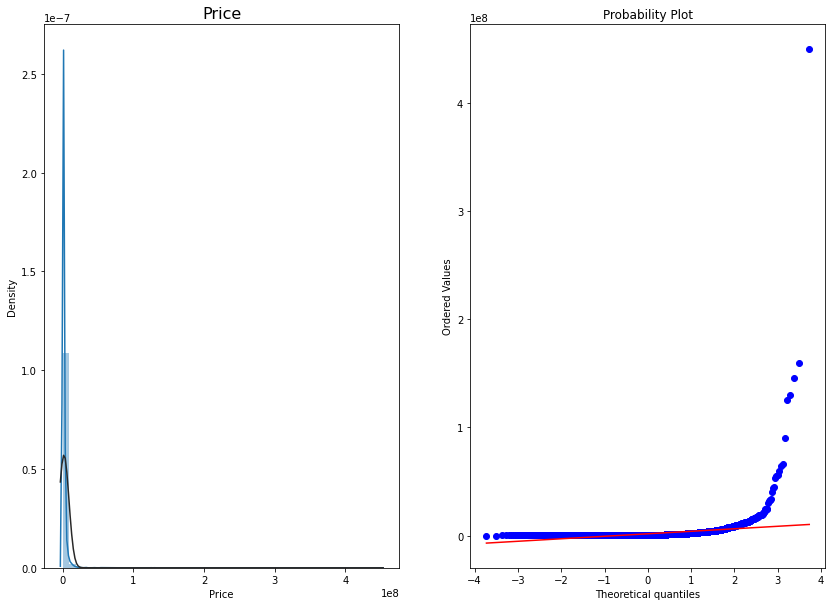

In [37]:
#Create a distribution plot to check the distribution of 'Price' data
#Create a probability plot to access if the data fits a normal distribution
import seaborn as sns
from scipy.stats import norm
from scipy import stats

#Plotting of distribution plot for 'Price'
plt.figure(figsize = (14, 10))
ax1=plt.subplot(121)
x1 = sns.distplot(train1["Price"], fit=norm)
x1.set_title('Price',fontsize=16)

#Plotting of probability plot for 'Price'
ax2=plt.subplot(122)
x2 = stats.probplot(train1["Price"], plot=plt)
plt.show()

In [38]:
#Log the 'Price' data in train and test dataset 
#This is to normalize the data and making it into a normal distribution
train1['Price'] = np.log(train1['Price'])
test1['Price'] = np.log(test1['Price'])

C:\Users\ROSC-01\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


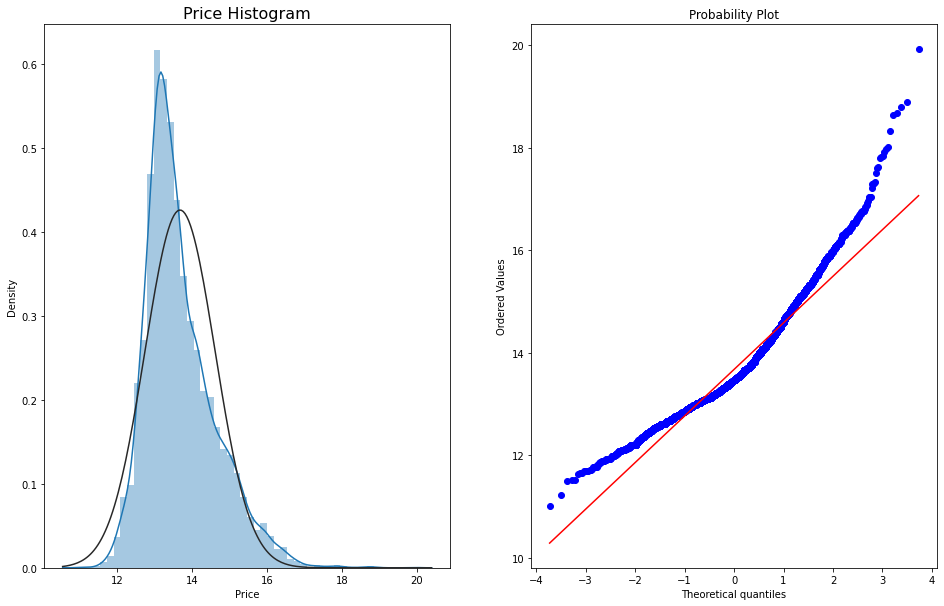

In [39]:
#Plot the distribution plot again to see if a normal distribution is achieved
plt.figure(figsize = (16, 10))
ax1=plt.subplot(121)
x1 = sns.distplot(train1["Price"], fit=norm)
x1.set_title('Price Histogram',fontsize=16)

#Plot the probability plot again to check for a linear fit
ax2=plt.subplot(122)
x2 = stats.probplot(train1["Price"], plot=plt)
plt.show()

In [40]:
#Drop the 'Price' variable in X_train1
X_train1 = train1.drop("Price", axis=1)

#Make y_train1 'Price' as the response variable for the train dataset
y_train1 = train1["Price"]

#Drop the 'Price' variable in X_test1
X_test1 = test1.drop("Price", axis=1)

#Make y_test1 'Price' as the response variable for the test dataset
y_test1 = test1["Price"]

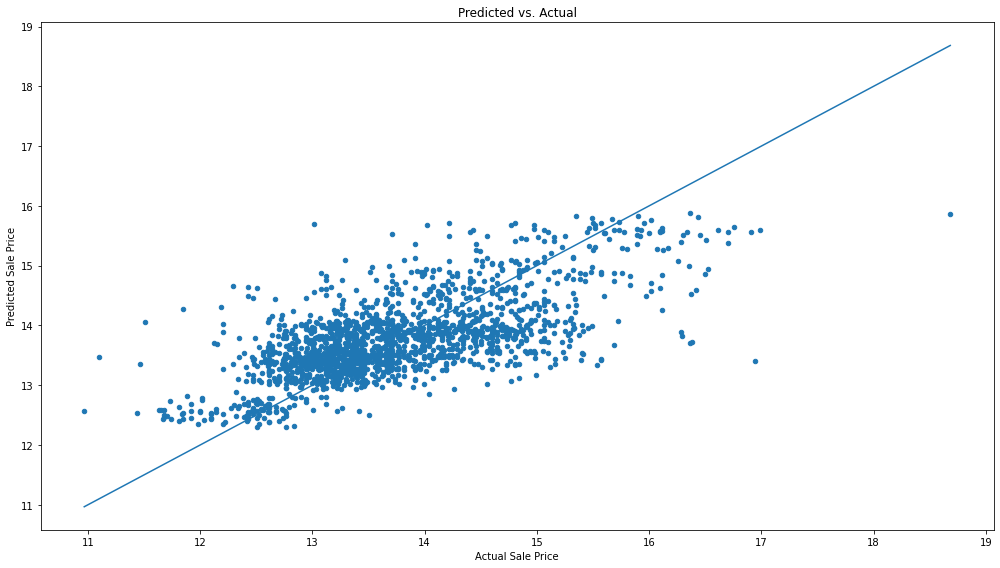

In [41]:
#Random Forest regressor
#import neccessary packages
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

#I set the number of trees to 200(n_estimators)
#min number of samples required to be at leaf node to 5 (min_samples_leaf)
#the number of features to consider when looking for the best split to 0.5 (max_features)
#number of jobs to run in parallel to -1, which means using all processors (n_jobs)
#score of the training dataset obtained using an out-of-bag estimate to True (oob_Score)
clf = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)

#instantiate a model
clf.fit(X_train1, y_train1)

#get predicted labels for the test data
y_pred = clf.predict(X_test1)

#plot a scatter plot (help explain)
plt.figure(figsize=(14, 8))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

<p>For Model Building, I partitioned the data into two separate datasets, which are the train and test datasets. The train dataset was distributed 80 percent of the data and test dataset with 20 percent. The model is trained with the training dataset that we had, then used to predict the 'Price' values of the test dataset. </p>

### <p style ="color: blue;">5. Model Evaluation</p>

<p>Model Evaluation aims to estimate the generalization accuracy of a model on future data. In the process of evaluating, we will evaluate the accuracy of our Random Forest regression model. We used holdout evaluation method to test a model on different data than it was trained on. This is to provide unbiased estimate of learning performance. The training set is a subset of the dataset used to build predictive models. Test set is a subset of the dataset used to access the likely future performance of our model.</p>

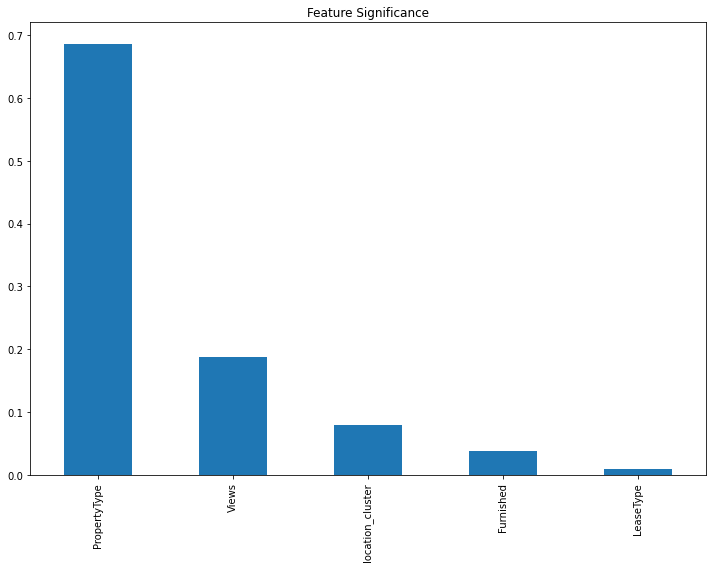

In [42]:
#Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
coef.head(20).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()
#The blue bars are the feature importances of the forest, which are the predictors 'PropertyType', 'Views', 'location_cluster', Furnished', 'LeaseType'

<p>I determined the attributes that have the greatest effect on the property value by using a forest of trees to evaluate the importance of features on an artificial classification task. Based on the feature importance coefficients from the predictive model, PropertyType has the largest impact on the predictive model,
followed by Views, location_cluster, Furnished and LeaseType. PropertyType has the biggest impact by far, while LeaseType has 
the least impact, which is not surprising, considering the correlation confidence interval explored between LeaseType and Price in the EDA process.</p>


In [43]:
#I used Root Mean Square Log Error(RMSLE) to determine the accuracy of prediction for the model
from sklearn import metrics
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Root Mean Squared Error: 0.6806735817237122


In [44]:
#I also used coefficient of determination to determine the accuracy of prediction for the model
from sklearn.metrics import r2_score 
a = y_test1
b = y_pred
R_square = r2_score(a, b) 
print('Coefficient of Determination', R_square)

Coefficient of Determination 0.4508548632028141


<p>The predictive model has a RMSE of 0.681 and R square value of 0.451. The R squared value of the model is unfortunately quite low, 0.451, which means only 0.451 of the price variation can be explained by the model's input. The model is thus not very accurate in predicting the price of a property based on its Lease Type, Property Type, Furnished status, number of views on the listing site, and location cluster.</p>


### <p style ="color: blue;">6. Model Validation</p>

<p>I used K-Fold cross-validation procedure for estimating the performance of my machine learning model. I used cross-validation to determine the optimal alpha value.</p>


In [45]:
#Import the package for RidgeCV class
from sklearn.linear_model import RidgeCV

#By default, the ridge regression cross validation class uses the 'Leave One Out' strategy 
#We can compare the performance of our model with different alpha values by taking a look at the mean square error.
regressor = RidgeCV(alphas=[1, 1e3, 1e6], store_cv_values=True)

#Instantiate the data
regressor.fit(X_train1, y_train1)

#Calculate mean squared error (MSE) to tell how close a regression line is to a set of points
cv_mse = np.mean(regressor.cv_values_, axis=0)
print(cv_mse)

[0.75938967 0.76227536 0.86087522]


In [46]:
#The RidgeCV class will automatically select the best alpha value
#Best alpha
print(regressor.alpha_)

1.0


In [47]:
#Predict the 'Price' variable for the test set
predict_y = regressor.predict(X_test1)

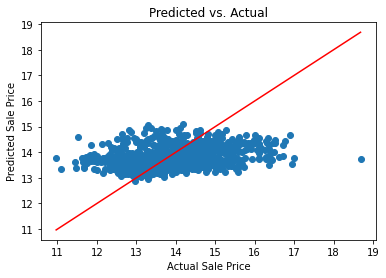

In [48]:
#plot scatter plot of test set
plt.scatter(y_test1, predict_y);
plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)], color='red')
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

In [49]:
#I used Root Mean Square Log Error(RMSLE) to determine the accuracy of prediction for the model
from sklearn import metrics
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predict_y, y_test1)))

Root Mean Squared Error: 0.8596259487056596


<p>In the K-Fold cross-validation, the training set is split into k smaller sets (or folds). The model is then trained using k-1 of the folds and the last one is used as the validation set to compute a performance measure such as accuracy.

The predictive performance of the model created is based on how well it performs outside the sample to a new test data set. I will only be able to grasp how well my model performs to my in-sample data without cross-validation. Based on the results of the cross-validation model, the root mean square error of the model is actually higher(0.860) than the previous decision tree regressor model value(0.681) which indicates that the set used in the previous decision tree regressor might have been a more optimistic set of data than the mean. K fold validation also shows us that in actuality there is even less of a linear relationship between the predicted and actual values, indicating lower accuracy of the model.</p>


### <p style ="color: blue;">7. Discussion</p>

<p>Based on the model that I created, property type had the strongest impact on a property's price. Properties of the 'Land', 'Bungalow' and 'Shop' have the highest prices. Properties with more views also have higher prices, since views are a strong indicator of demand. Furthermore, the location cluster of a property also affects prices. Properties that are furnished have higher prices, and lastly the lease type of a property slightly affects the price. 

Properties that have the best value in KL would be properties with property types of 'Land', 'Bungalow' or 'Shop', have high views on the listing website, be already fully furnished, have a Freehold lease type and finally be located in cluster 2 location. These properties have high prices or 'worth', and if the predictive model was more accurate, any properties that are listed below the predictive model's predicted price should be worth investing in.

With regards to the performance of the model and modelling approach, the model created, unfortunately, is not very accurate with a R-square value of only 0.451. Price is a continous variable with a very large range, and the model that I created only used 5 predictor attributes that were deemed significant from the EDA process to predict price. Additional attributes on the propsocial website like nearby ammenities and infrastructure e.g. schools, public transport near property listings were locked behind server javascript, and despite my attempt at using selenium to simulate clicking these webpages, I was unable to scrape this data, and therefore had limited access to more potential predictor attributes. Lease type was also used as a predictor attribute in the model despite not fulfilling the 95% confidence interval of correlation to price, but was added anyway due to almost fulfilling that interval. I decided to create clusters out of the latitude and longitude values of each property listing to meaningfully cluster locations as well, but perhaps a more standard approach of predicting price based on property address such as district or town might have yielded better results. Finally not all data from the propsocial website was scraped, as due to hardware limitations I was unable to scrap all index pages from the website. Future improvements towards the model could be to include more potential predictors, such as nearby amenities and reviews, as well as obtain a larger more comprehensive dataset of property listings, since the size of the dataset I used was limited by my hardware.</p> 
